## Test Notebook for modules in *spectral.py* and *feature.py*

**Dates:**  
18/02/2022, 21/02/2022, 19/04/2022   v0.6   
27/09/2022  v0.7   
31/10/2023: v0.8.0 on win11


In [1]:
#!pip install git+https://github.com/compi1234/pyspch.git
try:
    import pyspch
except ModuleNotFoundError:
    try:
        print(
        """
        To enable this notebook on platforms as Google Colab, 
        install the pyspch package and dependencies by running following code:

        !pip install git+https://github.com/compi1234/pyspch.git
        """
        )
    except ModuleNotFoundError:
        raise

In [2]:
%matplotlib inline
import os,sys, math
import numpy as np
import librosa

import pyspch.sp as Sps
import pyspch.core as Spch
import pyspch.display as Spd

import matplotlib.pyplot as plt
import matplotlib as mpl

mpl.rcParams['figure.figsize'] = [12.0, 8.0]
mpl.rcParams['font.size'] = 12
mpl.rcParams['legend.fontsize'] = 'large'
mpl.rcParams['figure.titlesize'] = 'large'

### Load a Data File and segmentation if available

In [3]:
root = 'https://homes.esat.kuleuven.be/~spchlab/data/'
name = 'misc/bad_bead_booed'
#name ='misc/b_8k'
#name = 'misc/friendly'
#name = 'timit/audio/train/dr1/fcjf0/si1027'


wavdata, sr = Spch.load_data(name+".wav",root = root)
#

if sr > 16000:
    wavdata, sr = Spch.load_data(name+".wav",root = root,sample_rate=16000) 
# get segmentations and convert TIMIT segmentations from sample indices to time, plus map from the TIMIT61 alphabet to CMU
dt = 1/sr if name.split('/')[0]=='timit' else 1.    # 1/sr for TIMIT files, 1. otherwise

# try to find a segmentation, grapheme or phoneme or word
seg = Spch.timit.read_seg_file(root+name+ ".gra",dt=dt,fmt='float32')
if seg is None: seg = Spch.timit.read_seg_file(root+name+ ".phn",dt=dt,fmt='float32',xlat='timit61_41')
if seg is None: seg = Spch.timit.read_seg_file(root+name+ ".wrd",dt=dt,fmt='float32')

WARNING(read_seg_file): reading/converting segmentation file https://homes.esat.kuleuven.be/~spchlab/data/misc/bad_bead_booed.gra failed


In [4]:
sr

16000

### 1. Fourier Spectrogram

Noteable differences with librosa:
- frame positioning is same as Kaldi/SPRAAK
    + frame i is positioned \[ i\*n_shift, (i+1)\*n_shift \] 
    + frame i is symmetrically extended to accomodate n_length and ultimately n_fft
    + padding via mirroring at the signal edges
    + n_frames = n_samples // n_shift
- all spectral routines can use the 'mode' argument to specify the input/output mode of the spectral representations; options are 'power','magnitude' and 'dB'
- 'S' denotes the power spectrum, 'spg' the log spectrum 

Multiple examples with various segmentations in spectrogram_tst.ipynb

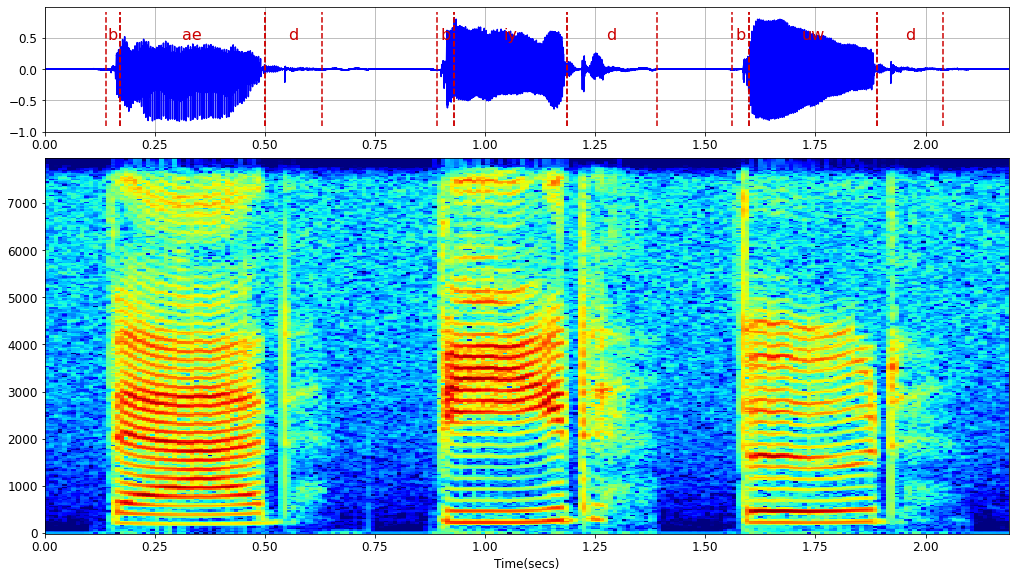

In [5]:
# compute a spectrogram as starting point for further analysis
shift=0.01
length=0.030
n_shift = int(shift*sr)
n_length = int(length*sr)
n_fft = 2**math.ceil(math.log2(n_length))
spg = Sps.spectrogram(wavdata,sample_rate=sr,f_shift=shift,n_mels=None,mode='dB')
(n_param,n_frames)=spg.shape
d_freq = sr/(2.*(n_param-1))
fig = Spd.PlotSpg(wavdata=wavdata,spgdata=spg,segwav=seg,sample_rate=sr,figsize=(14,8))
fig

### 2. Mel Spectrogram

- Don't forget to pass sample rate as argument in spg2mel !! to know how to fit the f2mel mapping
- You can set fmin and fmax for the range of the mel filterbank.  fmin defaults to 40Hz, fmax to 0.45\*sr; this is more tight than in librosa (full range) or even slightly more than Kaldi 

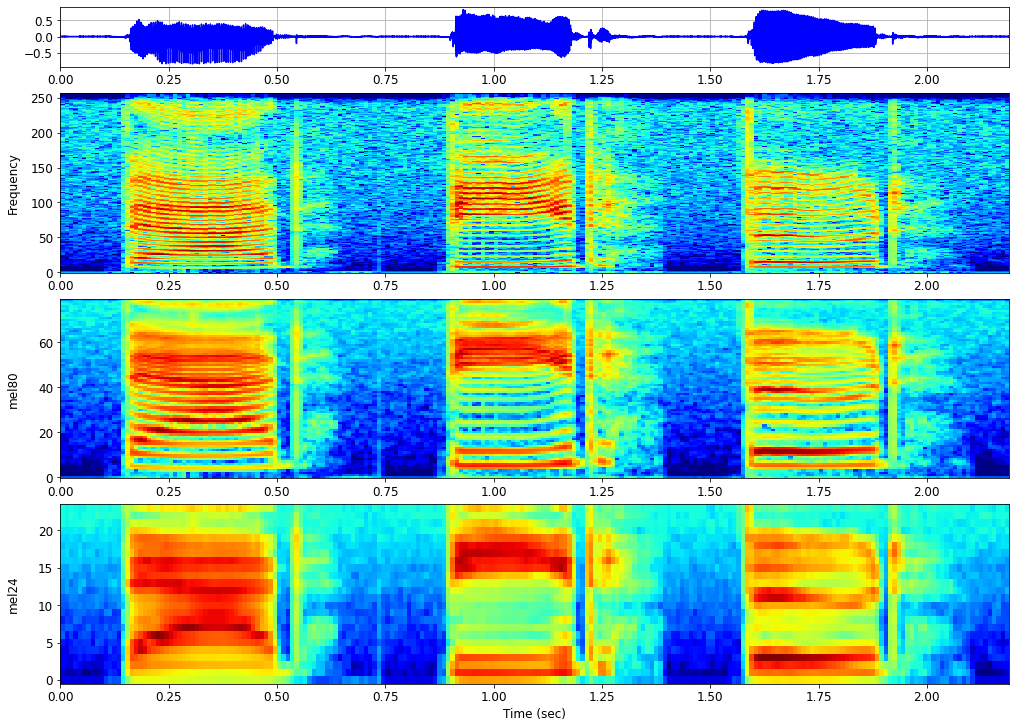

In [6]:
spg = Sps.spectrogram(wavdata,sample_rate=sr,n_mels=None,mode='dB')
spg_mel80 = Sps.spg2mel(spg,sample_rate=sr,n_mels=80,mode='dB')
spg_mel24 = Sps.spg2mel(spg,sample_rate=sr,n_mels=24,mode='dB')
Spd.PlotSpgFtrs(wavdata=wavdata,spgdata=spg,img_ftrs=[spg_mel80,spg_mel24],img_labels=['mel80','mel24'],sample_rate=sr,figsize=(14,10))

### 3. Cepstrum, Spectral Envelope & Residue

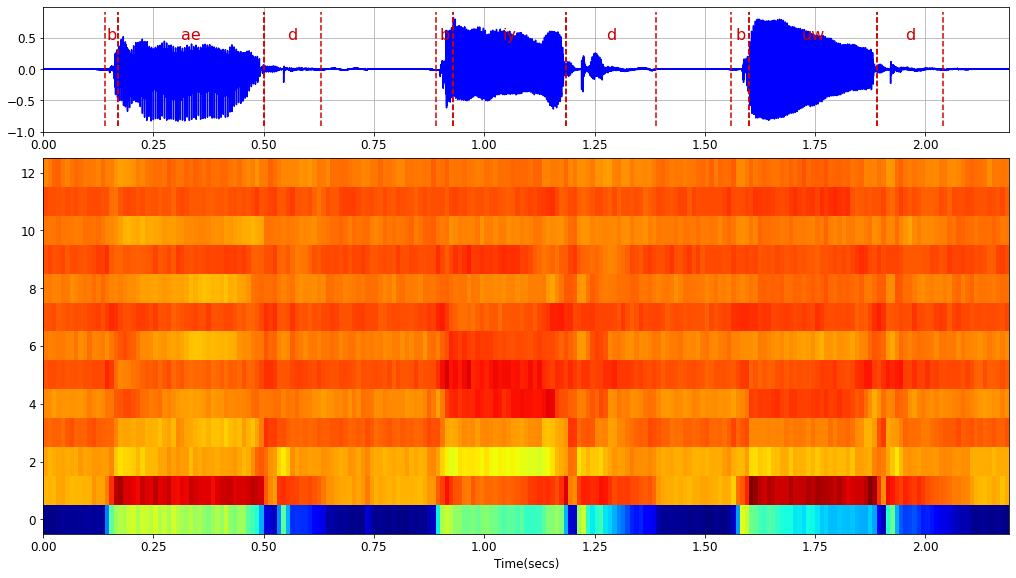

In [7]:
cep = Sps.cepstrum(S=spg,n_cep=13,mode='dB')
Spd.PlotSpg(wavdata=wavdata,spgdata=cep,segwav=seg,dy=1,sample_rate=sr,figsize=(14,8))

In [8]:
help(Spd.PlotSpgFtrs)

Help on function PlotSpgFtrs in module pyspch.display.display:

PlotSpgFtrs(wavdata=None, spgdata=None, segdata=None, line_ftrs=None, img_ftrs=None, row_heights=None, spglabel='Frequency', line_labels=None, img_labels=None, sample_rate=1.0, shift=0.01, dy=1, frames=None, Legend=False, **kwargs)
    General Purpose multi-tier plotting routine of speech signals.
    The figure contains
     - waveform + spectrogram (mandatory)
     - segmentations (list, optional)
     - img features (list, optional)
     - line features (list, optional)



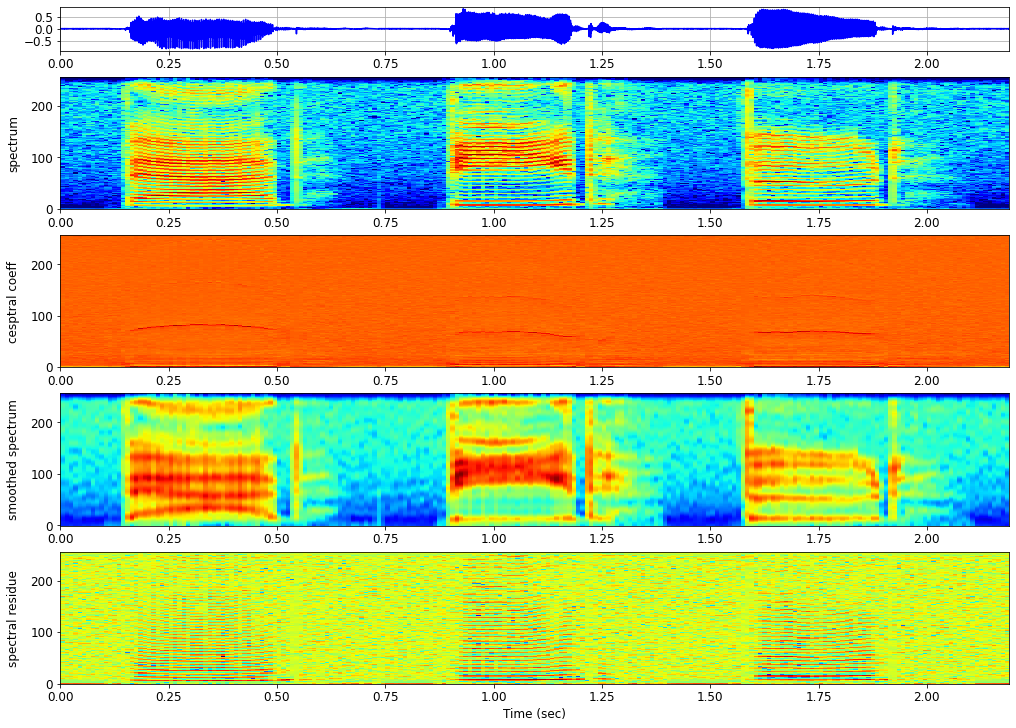

In [9]:
# frequency representations with 'bin' units
cep = Sps.cepstrum(S=spg,mode='dB')
n_lifter = 13 * sr//8000
spec_env, spec_res = Sps.cep_lifter(cep,n_lifter=n_lifter,n_spec=spg.shape[0])
Spd.PlotSpgFtrs(wavdata=wavdata,spgdata=spg, img_ftrs=[cep,spec_env,spec_res],dy=1,sample_rate=sr,
                spglabel='spectrum', img_labels=['cesptral coeff','smoothed spectrum','spectral residue'],figsize=(14,10))

### 4. Mel Cepstrum

The number of mel channels is not very important if ultimately reducing to a low number of MFCC coefficients.   See the difference between 24 and 80 channel mel filterbanks, for 13 MFCC coefficients

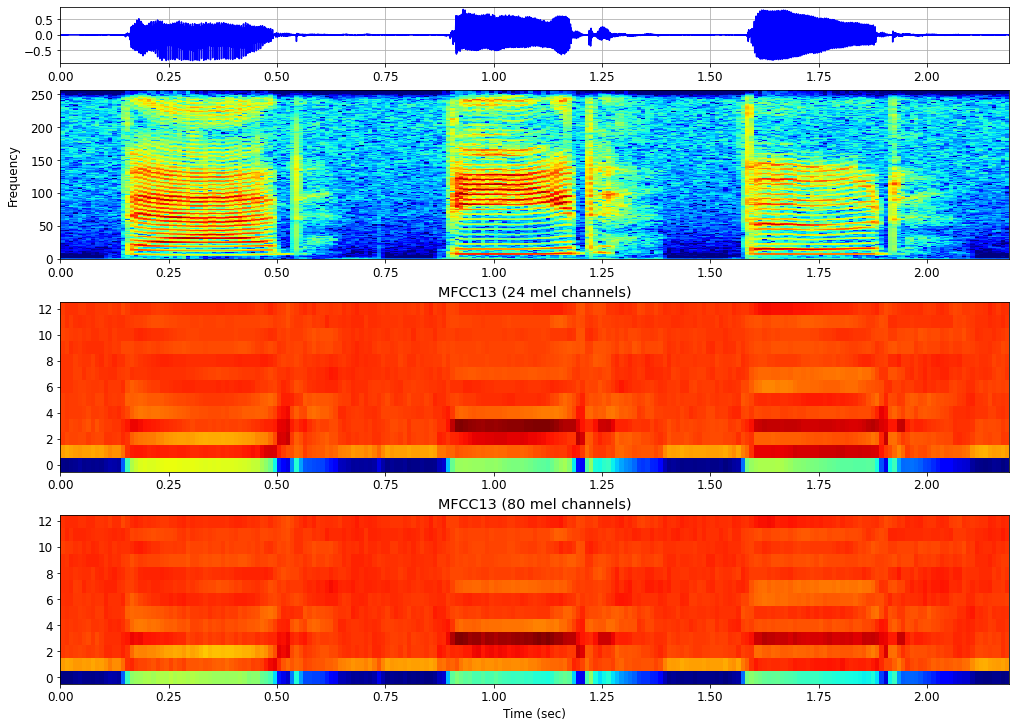

In [10]:
#spg = Sps.spectrogram(wavdata,sample_rate=sr,n_mels=None,mode='dB')
#spg_mel80 = Sps.spg2mel(spg,sample_rate=sr,n_mels=80,mode='dB')
#spg_mel24 = Sps.spg2mel(spg,sample_rate=sr,n_mels=24,mode='dB')
mfcc13 = Sps.cepstrum(S=spg_mel24,n_cep=13,mode='dB')
# alt: mfcc13 = Sps.melcepstrum(S=spg,sample_rate=sr,n_mels=24,n_cep=13)
mfcc13_80 = Sps.cepstrum(S=spg_mel80,n_cep=13,mode='dB')

fig = Spd.PlotSpgFtrs(wavdata=wavdata,spgdata=spg, img_ftrs=[mfcc13,mfcc13_80],dy=1,sample_rate=sr,figsize=(14,10))
fig.axes[2].set_title("MFCC13 (24 mel channels)")
fig.axes[3].set_title("MFCC13 (80 mel channels)")
display(fig)

## liftering on mel spectrum

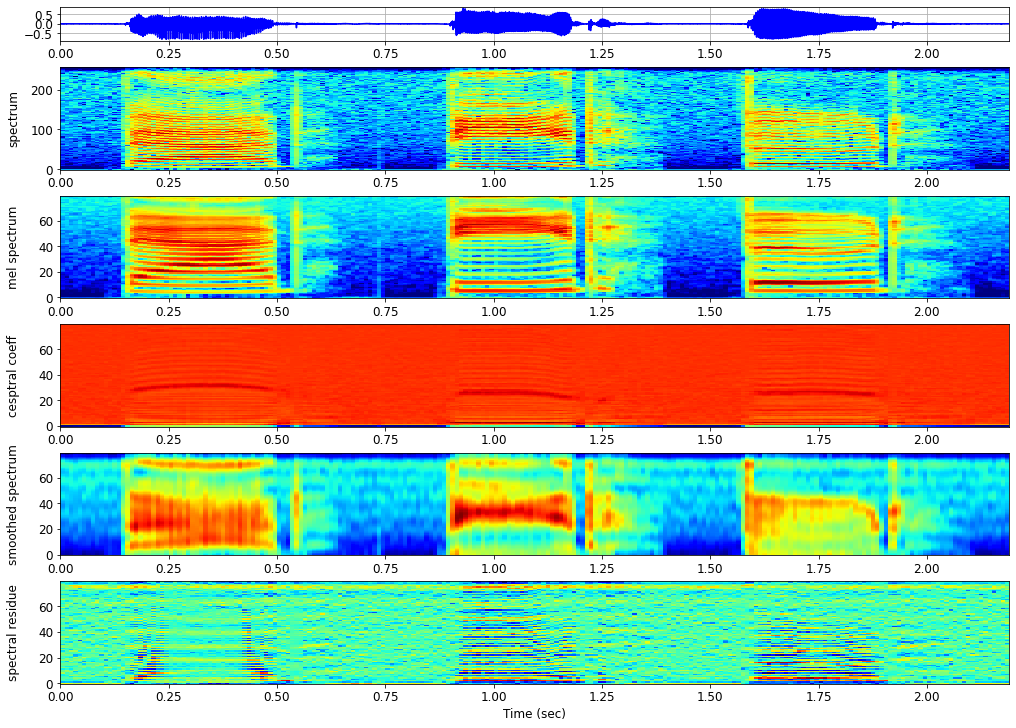

In [11]:

mfcc_80 = Sps.cepstrum(S=spg_mel80,mode='dB')
melspec_env, melspec_res = Sps.cep_lifter(cep,n_lifter=13,n_spec=80)
Spd.PlotSpgFtrs(wavdata=wavdata,spgdata=spg, img_ftrs=[spg_mel80,mfcc_80,melspec_env,melspec_res],dy=1,sample_rate=sr,
                spglabel='spectrum', img_labels=['mel spectrum','cesptral coeff','smoothed spectrum','spectral residue'],figsize=(14,10))

### 5. MFCC-39
add delta's and ddelta's, and finally mean_norm

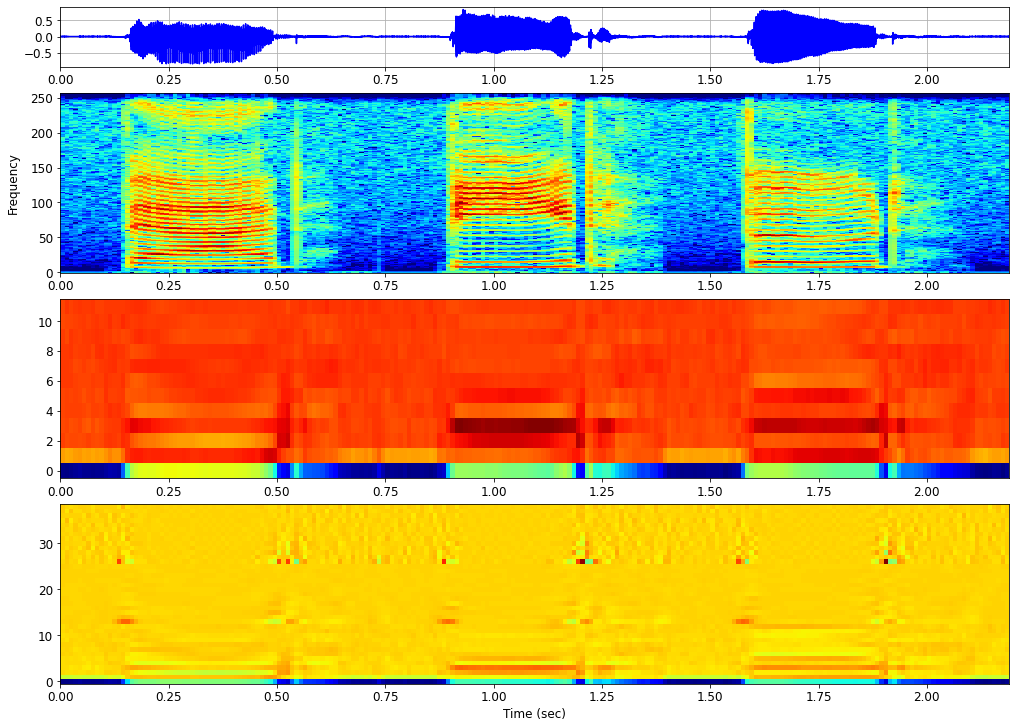

In [12]:
mfcc13 = Sps.melcepstrum(S=spg,sample_rate=sr,n_mels=24,n_cep=13)
ftrs = Sps.deltas(mfcc13,type="delta_delta2",Augment=True)
fig = Spd.PlotSpgFtrs(wavdata=wavdata,spgdata=spg, img_ftrs=[mfcc13[0:12,:],ftrs],dy=1,sample_rate=sr,figsize=(14,10))
display(fig)

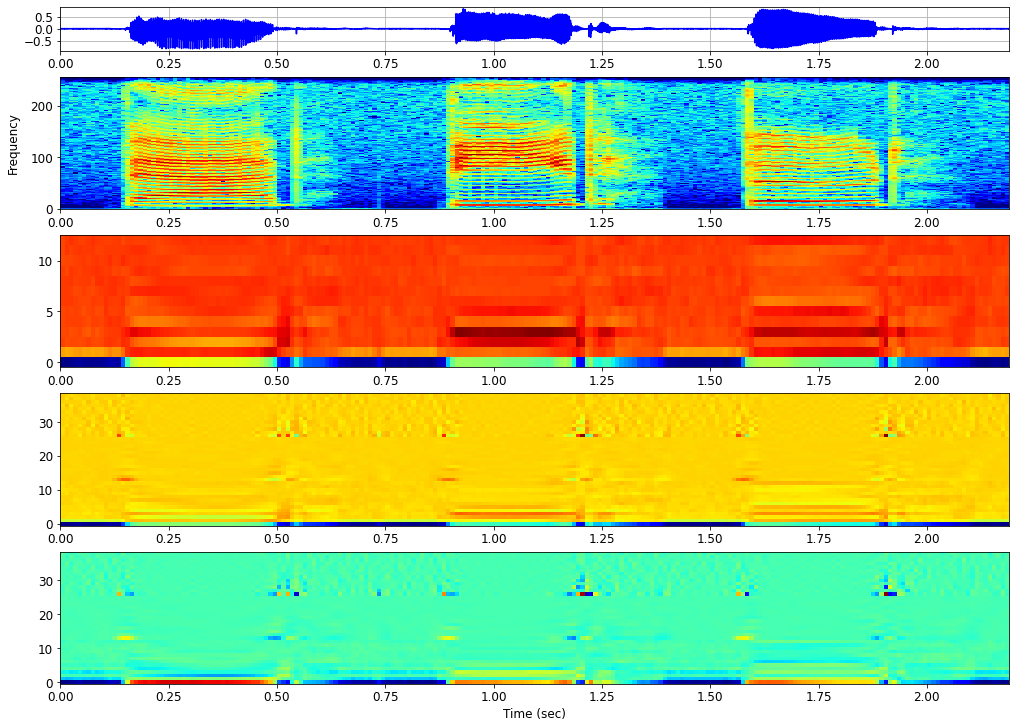

In [13]:
ftrs_n = Sps.mean_norm(ftrs)
fig = Spd.PlotSpgFtrs(wavdata=wavdata,spgdata=spg, img_ftrs=[mfcc13,ftrs,ftrs_n],dy=1,sample_rate=sr,figsize=(14,10))
display(fig)

### 6. Feature Splicing

In [14]:
X = [ [ 0,1,2] , [3,4,5] ]
X = np.array(X)
N=2
X, Sps.pad_frames(X,N=2), Sps.splice_frames(X,N=2,stride=2)

(array([[0, 1, 2],
        [3, 4, 5]]),
 array([[0, 0, 0, 1, 2, 2, 2],
        [3, 3, 3, 4, 5, 5, 5]]),
 array([[0, 0, 0],
        [3, 3, 3],
        [0, 0, 0],
        [3, 3, 3],
        [0, 1, 2],
        [3, 4, 5],
        [2, 2, 2],
        [5, 5, 5],
        [2, 2, 2],
        [5, 5, 5]]))

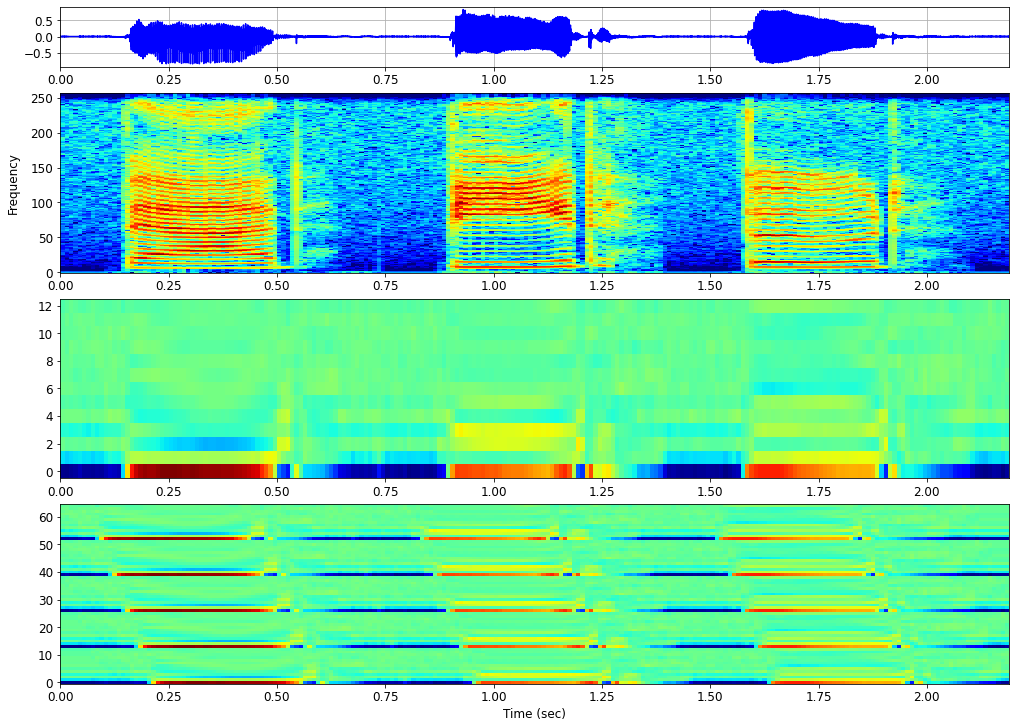

In [15]:
mfcc_n = Sps.mean_norm(mfcc13)
ftrs = Sps.splice_frames(mfcc_n,N=2,stride=3)
fig = Spd.PlotSpgFtrs(wavdata=wavdata,spgdata=spg, img_ftrs=[mfcc_n,ftrs],dy=1,sample_rate=sr,figsize=(14,10))
display(fig)

## 7. Standard Feature Processing
a. 39D MFCC's after mean norm  (perceptive field = 7 frames)   
b. 11*80 mel spectra (stride 2, perceptive field = 21 frames)   mean norm ?

In [16]:
spg = Sps.spectrogram(wavdata,sample_rate=sr,f_shift=shift)
mfcc13 = Sps.melcepstrum(S=spg,sample_rate=sr,n_mels=24,n_cep=13)
mfcc39 = Sps.deltas(Sps.mean_norm(mfcc13),type="delta_delta2",Augment=True)
mfcc39.shape

(39, 219)

In [17]:
mel80 = Sps.spg2mel(spg,sample_rate=sr,n_mels=80)
mel80s = Sps.splice_frames(mel80,N=5,stride=2)
mel80s.shape

(880, 219)

#### Comparing with the librosa implementation, either
- directly from waveform
- just from the mel spectrum

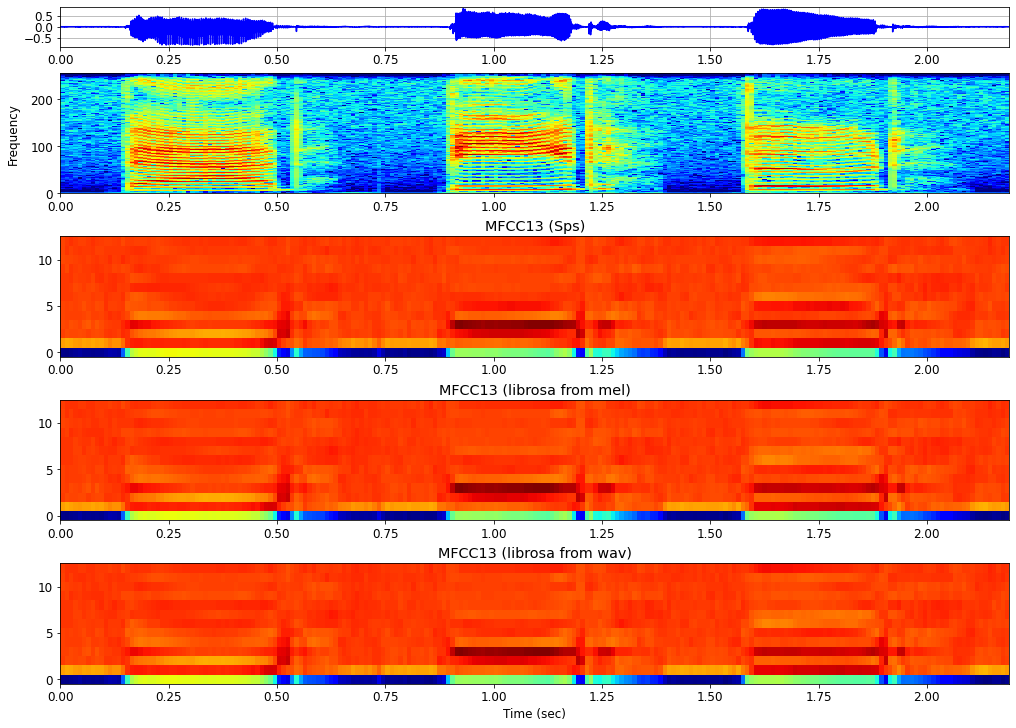

In [18]:
pad = (n_fft-n_shift)//2
y= Sps.preemp_pad(wavdata,pad=pad,preemp=.97)
mfcc_from_mel = librosa.feature.mfcc(S=spg_mel24, n_mfcc=13, dct_type=2, norm='ortho')
mfcc_from_wav = librosa.feature.mfcc(y=y,sr=sr,  n_mfcc=13, dct_type=2, norm='ortho',
                n_mels=24,hop_length=n_shift, win_length=n_length,n_fft=n_fft,window='hamm',center=False)
fig = Spd.PlotSpgFtrs(wavdata=wavdata,spgdata=spg, img_ftrs=[mfcc13,mfcc_from_mel,mfcc_from_wav],dy=1,sample_rate=sr,figsize=(14,10))
fig.axes[2].set_title("MFCC13 (Sps)")
fig.axes[3].set_title("MFCC13 (librosa from mel)")
fig.axes[4].set_title("MFCC13 (librosa from wav)")
display(fig)

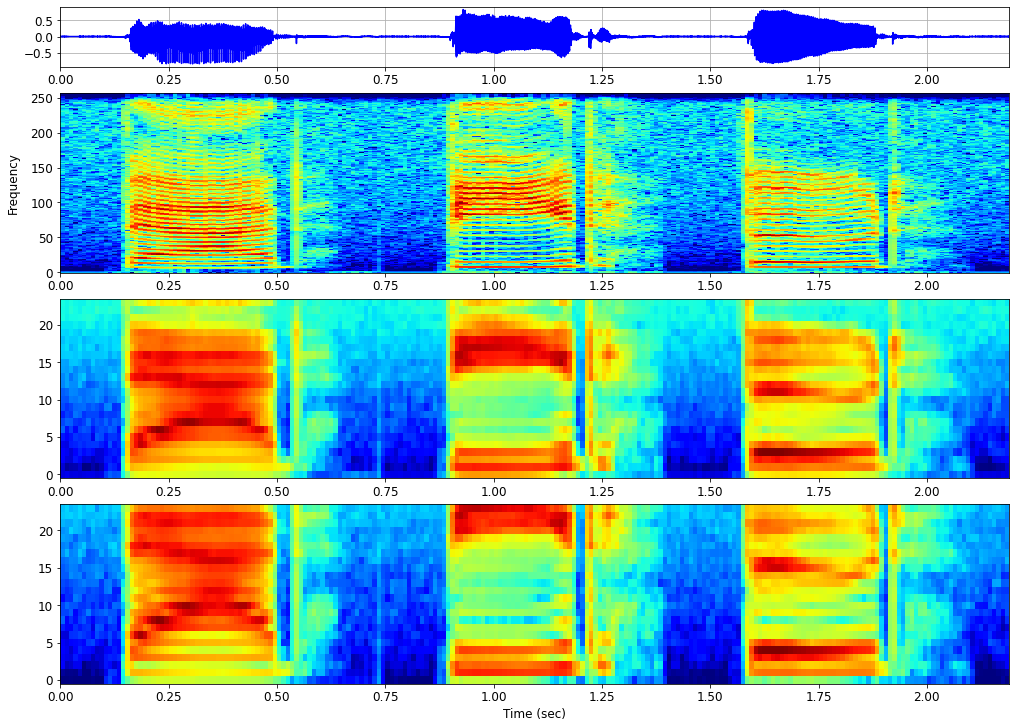

In [19]:
spg_mel24r = librosa.feature.melspectrogram(
    S=Sps.set_mode(spg,'dB','power'),fmin=40.,fmax=3600,
    n_mels=24,sr=sr)
spg_mel24r = Sps.set_mode(spg_mel24r,'power','dB')
Spd.PlotSpgFtrs(wavdata=wavdata,spgdata=spg,
                img_ftrs=[spg_mel24,spg_mel24r],
                sample_rate=sr,figsize=(14,10))